# Prepare Transformed Dataset

In [1]:
from data_base import Normalize, ToDFT, TacDataset
from torchvision import transforms

transform = transforms.Compose([Normalize(axis=0), ToDFT(32, flatten=True)])
ds = TacDataset('../data', transform=transform)

# Plot Dataset


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


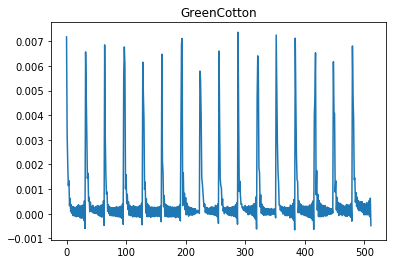

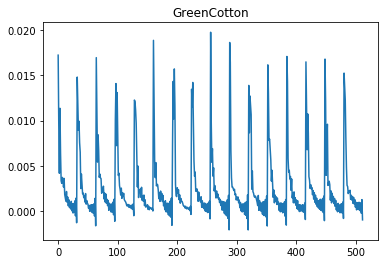

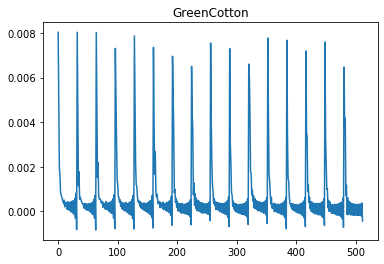

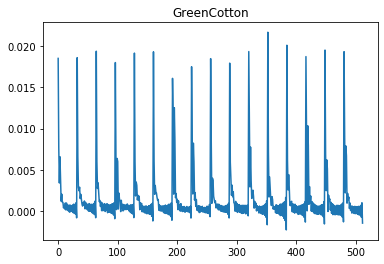

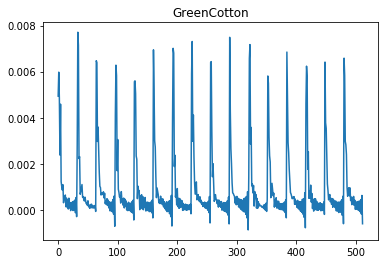

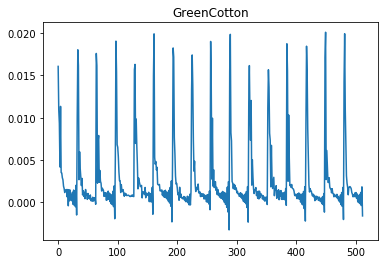

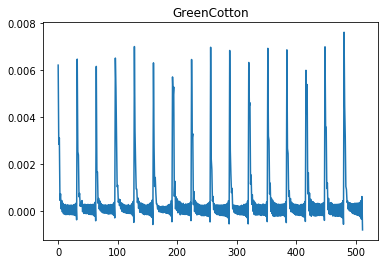

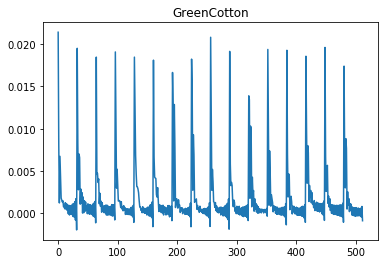

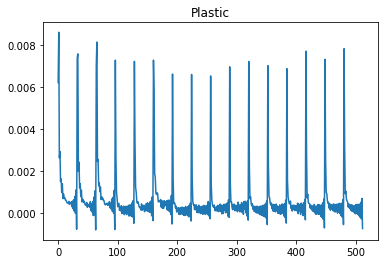

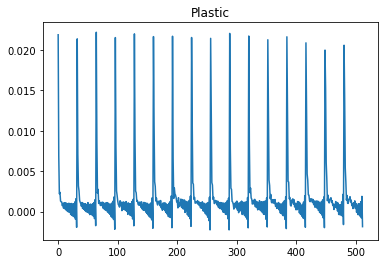

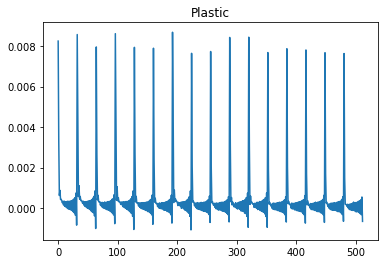

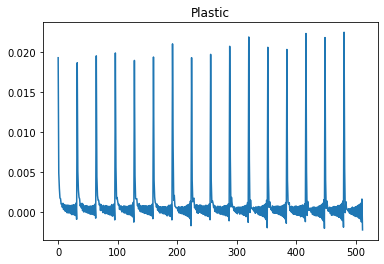

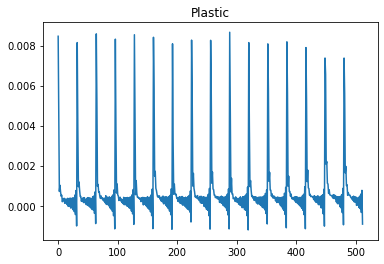

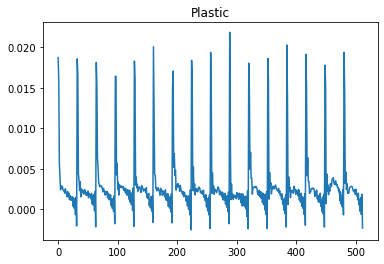

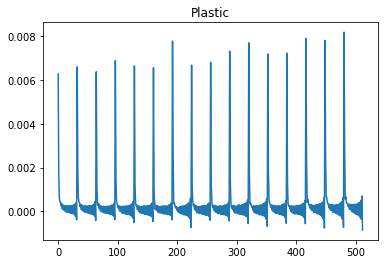

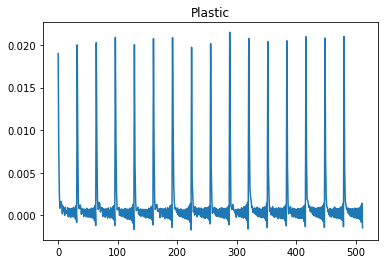

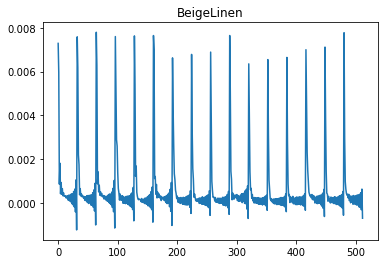

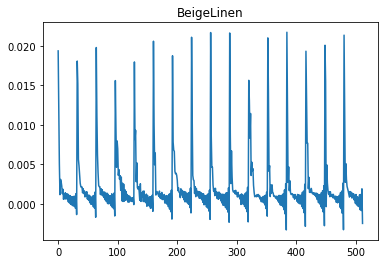

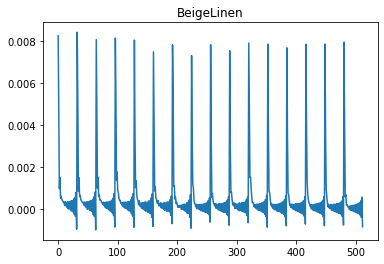

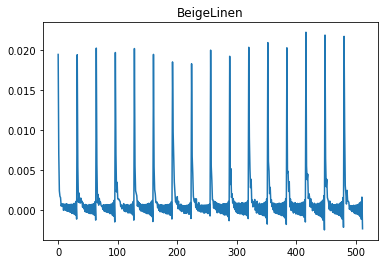

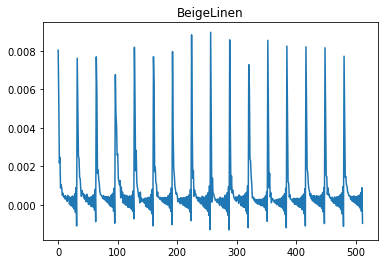

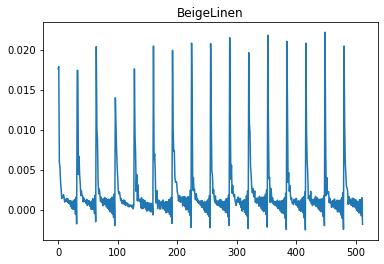

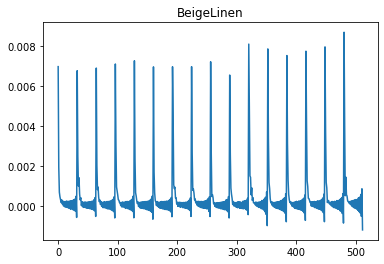

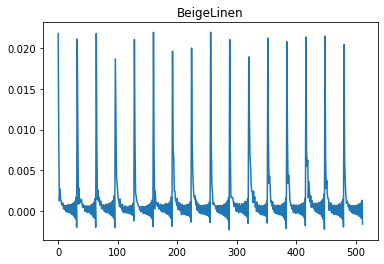

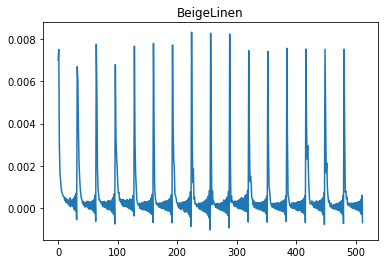

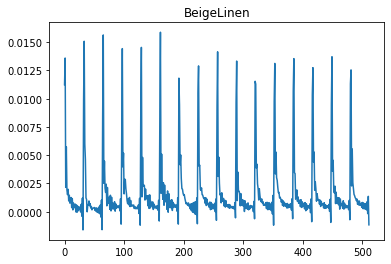

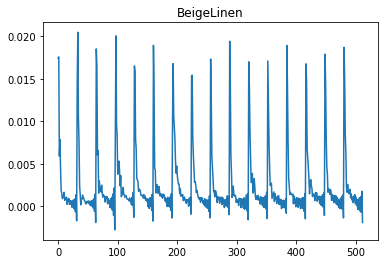

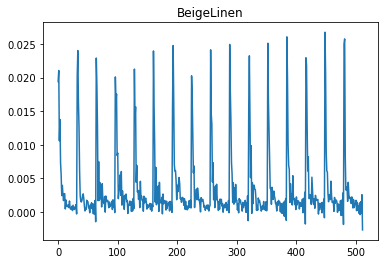

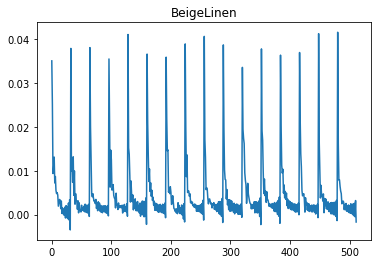

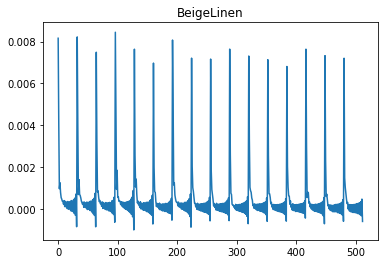

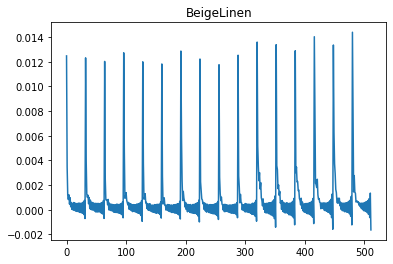

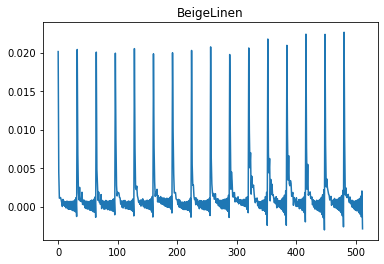

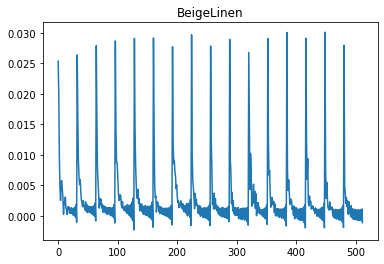

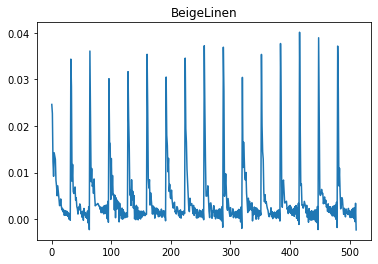

In [2]:
from matplotlib import pyplot as plt

for i, (sample, label) in enumerate(ds):
    plt.plot(sample)
    plt.title(ds.get_texture(label[0]))
    plt.show()

# Compress data with PCA
1. Compute covariance matrix for each multi-channel frequency series
2. Stack covariance matrix into a 3D covariance tensor $T \in \mathbb{R}^{C \times C \times N}$
3. Use core tensor $\mathcal{G}$ of the Tucker decomposition $T = \mathcal{G} \times_1 U_1 \times_2 U_2 \times_3 U_3$ as a compressed representation
4. Visualize the latent vectors

In [3]:
import numpy as np
from sklearn.decomposition import IncrementalPCA


data_array = []
labels, texture = [], []

for sample, label in ds:
    data_array.append(sample)
    texture.append(ds.get_texture(label[0]))
    labels.append(label)

Q = np.cov(np.asarray(data_array).T)
transformer = IncrementalPCA(n_components=3, batch_size=20)
transformer.partial_fit(Q)
Q_transformed = transformer.transform(Q)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Q3d = Q[:, :3]

df0 = pd.DataFrame(texture, columns=["texture"])
df1 = pd.DataFrame(labels, columns=["id", "pressure", "speed"])
df2 = pd.DataFrame(Q3d, columns=["x1", "x2", "x3"])
df  = pd.concat([df0, df1, df2], axis=1)

textures = df["texture"].unique()
pressures = df["pressure"].unique()
speeds = df["speed"].unique()
cmap = plt.cm.get_cmap("plasma", len(textures))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i, texture in enumerate(textures):
    X = df[df["texture"] == texture]
    x1, x2, x3 = X['x1'], X['x2'], X['x3'] 
    ax.scatter(x1, x2, x3, s=20, c=np.tile(cmap(i), (len(x1), 1)))
    ax.legend(textures)

plt.show()

ModuleNotFoundError: No module named 'ipympl'

In [14]:
%conda install -c conda-forge nodejs

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn import neighbors, datasets

n_neighbors = 10
train_ratio = 0.7

y = np.array(labels)
index = np.arange(len(y), dtype=int)
np.random.shuffle(index)
train_id = index[:int(train_ratio * len(index))]

clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(M[train_id, :], y[train_id])
rate = np.sum(clf.predict(M) == y)/len(y)
print("Classification accuracy: {:.2f}%".format(rate * 100))

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from ml_base import RVAE
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 2
EPOCHS = 100
INPUT_DIM = 1
NUM_CLASS = 4

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)